In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm  # Для прогресс-бара

In [17]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Путь к папке с данными
data_dir = "D:\\archive\\Train"  # Замените на свой путь

# Параметры
target_size = (64, 64)  # Размер изображений = 1   # 10% данных

# Создаем списки для хранения данных
images = []
labels = []

# Проходим по всем подпапкам (классам)
for class_id in tqdm(os.listdir(data_dir)):
    class_dir = os.path.join(data_dir, class_id)
    
    # Пропускаем файлы (если есть), работаем только с папками
    if not os.path.isdir(class_dir):
        continue
    
    # Получаем список всех изображений в классе
    all_images = os.listdir(class_dir)
    
    # Выбираем только часть изображений (10%)
    num_samples = int(len(all_images) * 1)
    sampled_images = np.random.choice(all_images, num_samples, replace=False)
    
    # Читаем выбранные изображения
    for img_name in sampled_images:
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:  # Проверка на успешное чтение
            img = cv2.resize(img, target_size)
            images.append(img)
            labels.append(int(class_id))

# Создаем датафрейм
df = pd.DataFrame({
    "image": images,
    "label": labels
})

# Проверяем датафрейм
print(df.head())
print(f"Всего изображений: {len(df)}")
print(f"Уникальных классов: {df['label'].nunique()}")

  2%|▏         | 1/43 [00:15<10:36, 15.15s/it]


KeyboardInterrupt: 

In [ ]:
'''Нормализация данных'''

df['image'] = df['image'].apply(lambda x: x / 255.0)  # [0, 1]

In [ ]:
from sklearn.model_selection import train_test_split

X = np.stack(df['image'].values)  # Преобразуем список изображений в numpy-массив
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% данных в тест
    random_state=42,
    stratify=y  # Сохраняет баланс классов
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,    # Поворот на ±10 градусов
    width_shift_range=0.1,  # Сдвиг по горизонтали
    height_shift_range=0.1, # Сдвиг по вертикали
    zoom_range=0.2,       # Случайное увеличение
    brightness_range=[0.9, 1.1]  # Изменение яркости
)

datagen.fit(X_train)  # Подгоняем генератор под данные

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Для борьбы с переобучением
    Dense(43, activation='softmax')  # 43 класса для GTSRB
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\artem\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.3770 - loss: 2.2966 - val_accuracy: 0.8953 - val_loss: 0.3914
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.7736 - loss: 0.6863 - val_accuracy: 0.9598 - val_loss: 0.1745
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8509 - loss: 0.4556 - val_accuracy: 0.9681 - val_loss: 0.1291
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.8862 - loss: 0.3436 - val_accuracy: 0.9819 - val_loss: 0.0841
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.9079 - loss: 0.2661 - val_accuracy: 0.9850 - val_loss: 0.0667
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.9229 - loss: 0.2205 - val_accuracy: 0.9865 - val_loss: 0.0547
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.9342 - loss: 0.1899 - val_accuracy: 0.9864 - val_loss: 0.0564
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3681s 4s/step - accuracy: 0.9414 - loss: 0.1703 - 

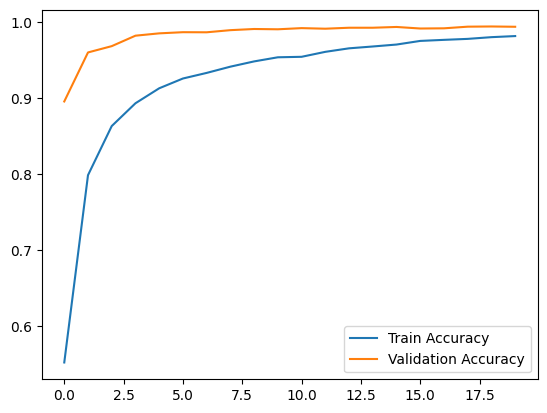

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


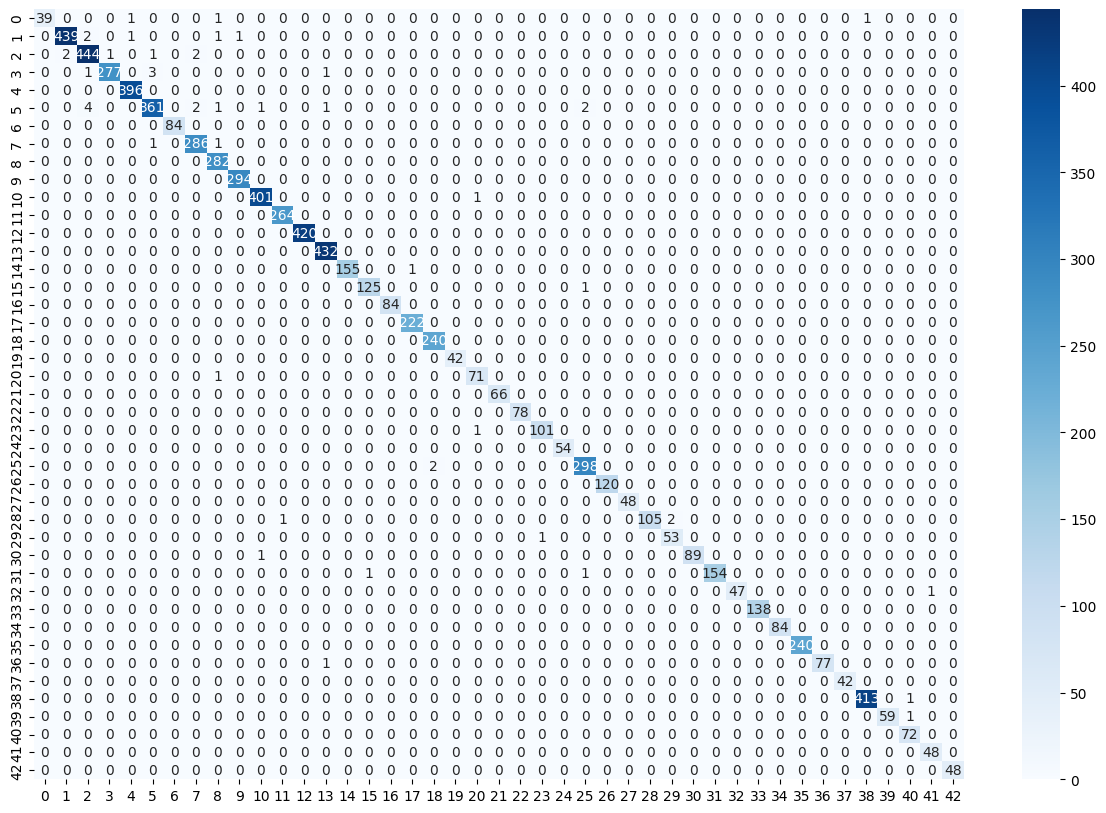

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


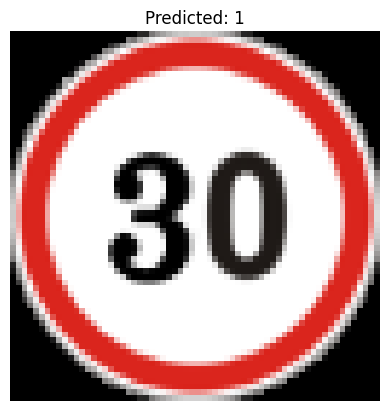

1

In [37]:
import cv2

def predict_image(image_path):
    # Загрузка и предобработка изображения
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV использует BGR по умолчанию
    img = cv2.resize(img, (64, 64))  # Размер должен соответствовать обучению
    img = img / 255.0  # Нормализация
    
    # Предсказание
    pred = model.predict(np.expand_dims(img, axis=0))
    predicted_class = np.argmax(pred)
    
    # Визуализация
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()
    
    return predicted_class

# Пример использования
predict_image("D:\\archive\\Meta\\1.png")  # Укажите путь к вашему тестовому изображению

In [ ]:
model.save('traffic_sign_model.keras')  # Формат Keras